In [1]:
# -*- encoding: utf-8 -*-

import argparse
import json
import cv2
import numpy as np
import os
from tqdm import tqdm
import random
import shutil
import os
import cv2
import tempfile
import time
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
from modelscope.outputs import OutputKeys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from PIL import Image
# retrieve the background image based on given text.
from model.background_retrieval import bk_img_retrieval
# Tool for write text on image.
from model.font_utils import PutText2Image

# the layout distribution predict model.
from model.distrib_model import LayoutsDistribModel
# the layout refinement model.
from model.layout_model import BBoxesRegModel
from model.color_selection import color_rotation_random

# smooth region detection and predict the distribution of layout.
from model.layout_distribution_predict import smooth_region_dectection, get_distrib_mask

# refine the layout bounding boxxes.
from model.layout_refine import get_batch_text_region, get_bbox_mask, get_refine_bboxes
from matplotlib import pyplot as plt
%matplotlib inline

2023-04-23 13:06:30,399 - modelscope - INFO - PyTorch version 1.13.1 Found.
2023-04-23 13:06:30,403 - modelscope - INFO - Loading ast index from /home/11911607/.cache/modelscope/ast_indexer
2023-04-23 13:06:30,433 - modelscope - INFO - Loading done! Current index file version is 1.4.2, with md5 77626287a64923b60bd423048b30f30b and a total number of 842 components indexed


In [2]:
STD_WIDTH, STD_HEIGHT = 300, 400
MIN_VALUE = -999999
MAX_BBOX_NUM = 32

def draw_figure(mask_list, layers, height, width):
    figure_mask = np.zeros((height, width, 3))
    for mask, layer in zip(mask_list, layers):
        figure_mask[:, :, layer] = mask / mask.max()
    figure_mask = cv2.resize(figure_mask, (width, height))
    return figure_mask * 255

def save_process_to_figure(
    saliency_map, 
    smooth_region_mask, 
    bbox_distrib_map, 
    initial_bbox_mask,
    refined_bbox_mask,
    height, width,
    save_folder):
    '''
    Save the poster generation process to figure, such as sailency map and etc.
    '''
    initial_bbox_mask = cv2.resize(initial_bbox_mask[0], (width, height))
    smooth_region_mask = cv2.resize(smooth_region_mask[0], (width, height))
    bbox_distrib_map = cv2.resize(bbox_distrib_map, (width, height))
    refined_bbox_mask = cv2.resize(refined_bbox_mask[0], (width, height))

    cv2.imwrite(os.path.join(save_folder, "candidate_regions.jpg"), smooth_region_mask * 255)
    cv2.imwrite(os.path.join(save_folder, "layout_distribution.jpg"), bbox_distrib_map * 255)

    smooth_region_figure = draw_figure(
        [saliency_map, smooth_region_mask], 
        [0, 2],
        height, width)
    cv2.imwrite(os.path.join(save_folder, "saliency_map_with-smooth.jpg"), smooth_region_figure)

    layout_distribution_figure = draw_figure(
        [saliency_map, bbox_distrib_map], 
        [0, 2],
        height, width)
    cv2.imwrite(os.path.join(save_folder, "saliency_map_with-layout-distribution.jpg"), layout_distribution_figure)

    initial_layout_figure = draw_figure(
        [initial_bbox_mask, bbox_distrib_map, saliency_map], 
        [2, 1, 0],
        height, width)
    cv2.imwrite(os.path.join(save_folder, "initial_layout.jpg"), initial_layout_figure)

    refined_layout_figure = draw_figure(
        [refined_bbox_mask, bbox_distrib_map, saliency_map], 
        [2, 1, 0],
        height, width)
    cv2.imwrite(os.path.join(save_folder, "refined_layout.jpg"), refined_layout_figure)
    return

In [3]:
def get_frame_candidates_sam(result, video_path):
    top_n = 10
    t_bins = []
    for bins in result['output']:
        t_bins.append(bins['frame'])
    
    top_n = 10
    idxs = []
    for t_bin in t_bins:
        for i in range(t_bin[0], t_bin[1]):
            idxs.append(i)

    idx = random.sample(idxs, top_n)
    print(f'candidates indexes:{idx}')

    cap = cv2.VideoCapture(video_path)
    frames = []
    for i in range(top_n):
        frame_index = idx[i]
        # 定位到指定帧
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        frames.append(frame)

    frame_size = (frame.shape[1], frame.shape[0])
    bg_dir = "bg_img"
    num_bg = 10

    # 获取bg_dir目录下所有png文件的路径
    bg_files = [os.path.join(bg_dir, f) for f in os.listdir(bg_dir) if f.endswith('.png')]

    # 随机选择num_bg个文件，并将读取得到的图像添加到frames列表中
    bgs = []

    for i, f in enumerate(random.sample(bg_files, num_bg)):
        img = cv2.imread(f)
        img = cv2.resize(img, frame_size) 
        
        seg = frames[i]#random.choice(frames)
        # seg = universal_matting(seg)
        predictor.set_image(seg)
        input_box = np.array([0, 0, frame_size[0], frame_size[1]])
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box,
            multimask_output=False,
        )
        # print(masks.shape,masks)
        # masks = np.expand_dims(masks, axis=-1)  # 在最后一个轴上添加一个维度
        masks = np.tile(masks, (3, 1, 1))
        masks = np.transpose(masks, (1, 2, 0))
        inverted_masks = ~masks
        # print(inverted_masks)

        bg = seg * inverted_masks
        fg = img * masks
        bgs.append(bg + fg)

    bgs += frames
    return bgs

In [11]:
def get_frame_candidates(result, video_path):
    top_n = 10
    t_bins = []
    for bins in result['output']:
        t_bins.append(bins['frame'])
    
    top_n = 10
    idxs = []
    for t_bin in t_bins:
        for i in range(t_bin[0], t_bin[1]):
            idxs.append(i)

    idx = random.sample(idxs, top_n)
    print(f'candidates indexes:{idx}')

    cap = cv2.VideoCapture(video_path)
    frames = []
    for i in range(top_n):
        frame_index = idx[i]
        # 定位到指定帧
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        frames.append(frame)

    frame_size = (frame.shape[1], frame.shape[0])
    bg_dir = "bg_img"
    num_bg = 10

    # 获取bg_dir目录下所有png文件的路径
    bg_files = [os.path.join(bg_dir, f) for f in os.listdir(bg_dir) if f.endswith('.png')]

    # 随机选择num_bg个文件，并将读取得到的图像添加到frames列表中
    bgs = []
    universal_matting = pipeline(Tasks.universal_matting,model='damo/cv_unet_universal-matting')
    for i, f in enumerate(random.sample(bg_files, num_bg)):
        # print(f)
        img = cv2.imread(f)
        img = cv2.resize(img, frame_size) 
        seg = frames[i]#random.choice(frames)
        seg = universal_matting(seg)
        seg = seg[OutputKeys.OUTPUT_IMG]
        alpha = seg[:, :, 3]
        
        # 寻找不透明区域的位置
        y, x = alpha.nonzero()

        # 计算裁剪边界
        top = max(min(y), 0)
        left = max(min(x), 0)
        bottom = min(max(y), seg.shape[0] - 1)
        right = min(max(x), seg.shape[1] - 1)

        # 裁剪图像
        cropped = seg[top:bottom, left:right]

        # 贴图
        height, width = img.shape[:2]
        c_height, c_width = cropped.shape[:2]

        # 随机选择一个位置贴图
        x = random.randint(0, width - c_width)
        y = random.randint(0, height - c_height)

        # 分离图标的BGR颜色通道和Alpha通道
        cropped_mask = cropped[:, :, 3]
        cropped_mask_inv = cv2.bitwise_not(cropped_mask)
        cropped_bgr = cropped[:, :, :3]

        # 将图标复制到背景图上
        roi = img[y:y+c_height, x:x+c_width]
        cropped_bgr = cv2.resize(cropped_bgr, (roi.shape[1], roi.shape[0]))
        cropped_mask_inv = cv2.resize(cropped_mask_inv, (roi.shape[1], roi.shape[0]))
        bg = cv2.bitwise_and(roi, roi, mask=cropped_mask_inv)
        fg = cv2.bitwise_and(cropped_bgr, cropped_bgr, mask=cropped_mask)
        img[y:y+c_height, x:x+c_width] = cv2.add(bg, fg)

        bgs.append(img)

    bgs += frames
    return bgs

In [84]:
import cv2
import random

def get_unused_grays(hist, vertical_thresh=0.00):  
    max_value = np.max(hist)  
  
    thresh = max_value * vertical_thresh  
    unused_grays = np.where(hist <= thresh)[0]  
  
    return unused_grays

def get_design_colors(unused_grays, min_margin=16):
    if min_margin <= 0:
        return unused_grays
    edge_colors = []
    length = len(unused_grays)
    concat_grays = [-1]
    concat_grays += unused_grays
    concat_grays.append(256)
    last_right_G = -1
    
    for i in range(1, length+1):
        left_G = concat_grays[i - 1]
        current_G = concat_grays[i]
        
        if current_G - left_G != 1 and current_G -1 != last_right_G:
            edge_colors.append(current_G - 1)
        
        right_G = concat_grays[i + 1]
        
        if right_G - current_G != 1:
            last_right_G = current_G + 1
            edge_colors.append(last_right_G)
    
    color_valid_info = np.zeros(256,)
    for g in unused_grays:
        color_valid_info[g] = 1
    for c in edge_colors:
        left_index = int(max(0, c - min_margin))
        right_index = int(min(256, c + min_margin + 1))
        color_valid_info[left_index:right_index] = 0
    
    colors = np.where(color_valid_info==1)[0]
    return colors

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 252, 253, 254, 255]
[0, 1, 2, 3, 4, 254, 255]


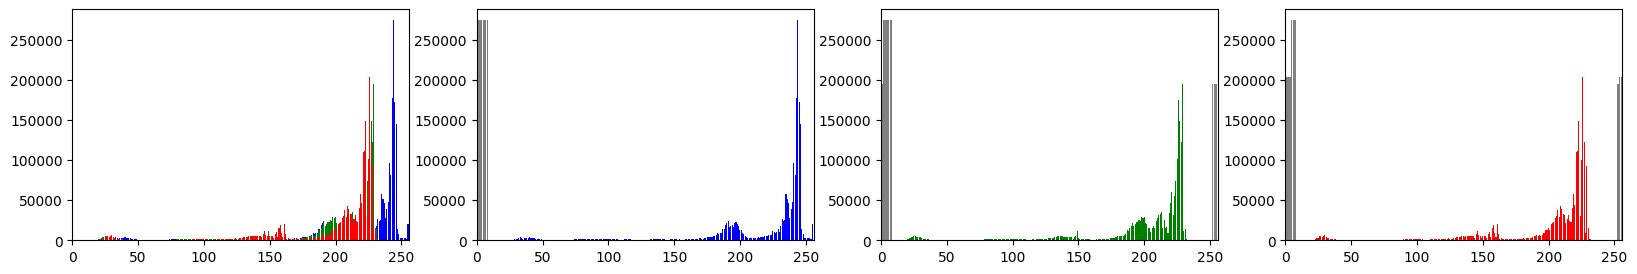

In [81]:
plt.figure(figsize=(20,3))
plt.subplot(1, 4, 1)
img = cv2.imread('jntm.png')

for i,col in enumerate(('b','g', 'r')):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    hist = np.squeeze(histr)
    plt.bar([j for j in range(0,256)], hist, color = col)
    
    plt.xlim([0,256])

indicates = 250000 * np.zeros(256)
for i,col in enumerate(('b','g', 'r')):
    plt.subplot(1, 4, i+2)
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    hist = np.squeeze(histr)
    
    unused_grays = list(get_unused_grays(hist))
    unused_grays = get_design_colors(unused_grays)
    print(list(unused_grays))
    
    plt.bar([j for j in range(0,256)], hist, color = col)
    indicates[unused_grays] = max(hist)
    plt.bar([j for j in range(0,256)], indicates, color = 'gray')
    
    plt.xlim([0,256])

plt.show()

In [7]:
def eval_covers(output_path):
    print("with backgrounds from base:")
    os.system(f'python -m pytorch_fid {output_path}/w_bg ./real_data')
    print()
    print("without backgrounds from base:")
    os.system(f'python -m pytorch_fid {output_path}/wo_bg ./real_data')

def draw_stickers(img, width, height):    
    stickers_folder = 'stickers'
    stickers_files = [f for f in os.listdir(stickers_folder) if f.endswith('.png')]
    random_stickers_file = random.choice(stickers_files)
    stickers_path = os.path.join(stickers_folder, random_stickers_file)

    stickers = cv2.imread(stickers_path, cv2.IMREAD_UNCHANGED)
    c_height, c_width = stickers.shape[:2]

    # 随机选择一个位置贴图
    x = random.randint(0, width - c_width)
    y = random.randint(0, height - c_height)

    # 分离图标的BGR颜色通道和Alpha通道
    stickers_mask = stickers[:, :, 3]
    stickers_mask_inv = cv2.bitwise_not(stickers_mask)
    stickers_bgr = stickers[:, :, :3]

    # 将图标复制到背景图上
    roi = img[y:y+c_height, x:x+c_width]
    stickers_bgr = cv2.resize(stickers_bgr, (roi.shape[1], roi.shape[0]))
    stickers_mask_inv = cv2.resize(stickers_mask_inv, (roi.shape[1], roi.shape[0]))
    bg = cv2.bitwise_and(roi, roi, mask=stickers_mask_inv)
    fg = cv2.bitwise_and(stickers_bgr, stickers_bgr, mask=stickers_mask)
    img[y:y+c_height, x:x+c_width] = cv2.add(bg, fg)
    return img

In [96]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_text_file", type=str, dest = "input_text_file", default="example/input_elements_2.json")
    parser.add_argument("--output_folder", type=str, dest = "output_folder", default="example/outputs_2")
    # parser.add_argument("--background_folder", type=str, dest = "background_folder", default="bk_image_folder")
    parser.add_argument("--save_process", action='store_true', default=False)
    parser.add_argument("--eval", type=bool, default=True)
    parser.add_argument("--top_n", type=int, dest = "top_n", default=20)
    parser.add_argument("--draw_stickers", type=bool, default=False)
    parser.add_argument("--show_covers", type=bool, default=True)
    parser.add_argument("--show_process", type=bool, default=False)
    parser.add_argument("--iter_rounds", type=int, default=30)
    
    args = parser.parse_args([])
    print(args)
    
    start_time = time.time()
    # load the input text elements.
    if not os.path.exists(args.output_folder):
        os.mkdir(f'{args.output_folder}')
        os.mkdir(f'{args.output_folder}/w_bg')
        os.mkdir(f'{args.output_folder}/wo_bg')
    
    f = open(args.input_text_file, "r")
    input_elements = json.load(f) 
    f.close()
    print(input_elements)
    
    video_path = input_elements["video_path"]
    background_query = input_elements["background_query"]
    sentences = input_elements["sentences"]
    data_len = len(sentences)

    tmp_dir = tempfile.TemporaryDirectory().name
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    model_id = 'damo/cv_clip-it_video-summarization_language-guided_en'
    summarization_pipeline = pipeline(Tasks.language_guided_video_summarization, model=model_id,tmp_dir=tmp_dir)
    result = summarization_pipeline((video_path, background_query))

    print("Background retrieval query:", background_query)
    image_list = get_frame_candidates(result, video_path)
    covers = []

    for i, img in enumerate(tqdm(image_list[:args.top_n])):
        
        width, height = img.shape[1], img.shape[0]
        img_size = (width, height)
        text_size = height // 7
        
        if args.draw_stickers:
            img = draw_stickers(img, width, height)
            
        smooth_region_mask, regions, saliency_map = smooth_region_dectection(img)
        bbox_distrib_map = get_distrib_mask(smooth_region_mask)
        bbox_size_array = np.zeros((len(sentences), 2))
        
        ft_center_list = []
        
        # Estimate the size of the text box.
        for j, text_info in enumerate(sentences):
            font = random.choice([f for f in os.listdir('./font_files') if f.endswith('.ttf')])
            # print(font)
            font_file = f'./font_files/{font}'
            print(text_info,font_file)
            ft_center = PutText2Image(font_file)
            bbox_size_array[j] = ft_center.get_text_bbox_size(text=text_info, text_size=text_size)
            ft_center_list.append(ft_center)
        
        # initial layout, sampled by the maximum probability above the bbox_distrib_map.
        initial_bboxes = get_batch_text_region(bbox_distrib_map, bbox_size_array, img_size)
        initial_bbox_mask = get_bbox_mask(initial_bboxes, data_len)

        # The data used to refine the layout.
        initial_data = {"len_info": data_len, 
                    "shifted_mask": initial_bbox_mask.copy(),
                    "shifted_bbox": initial_bboxes.copy(),
                    "bbox_distrib_map": bbox_distrib_map.copy(),
                    "smooth_region_mask": smooth_region_mask.copy()}
        
        # The refined layout.
        refined_bboxes, refined_bbox_size, order = get_refine_bboxes(initial_data, args.iter_rounds)
        refined_bbox_mask = get_bbox_mask(refined_bboxes[None, :], data_len)

        # scale the layout to the image size.
        refined_bboxes[:, (0, 2)] = refined_bboxes[:, (0, 2)] / STD_WIDTH * width
        refined_bboxes[:, (1, 3)] = refined_bboxes[:, (1, 3)] / STD_HEIGHT * height
                
        # save the final poster picture.
        bk_img = img.copy()
        bk_img = bk_img / 1.1
        bk_img = bk_img.astype(np.uint8)
        text_color = [255, 255, 255]
        
        if args.show_process:
            plt.figure(figsize=(50,20))
        
        for j in range(len(sentences)):
            text_position = (refined_bboxes[j][0], refined_bboxes[j][1])
            text_hw = (refined_bboxes[j][2], refined_bboxes[j][3])
            text = sentences[order[j]]
            indicates = 250000 * np.zeros(256)
            region = bk_img[text_position[1]:text_position[1] + text_hw[1], text_position[0]:text_position[0] + text_hw[0]]
            
            if args.show_process:
                plt.subplot(data_len ,5, 1+j*5)
                plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
                plt.axis('off') # 去掉坐标轴
            
            for k,col in enumerate(('b', 'g', 'r')):
                
                histr = cv2.calcHist([region],[k],None,[256],[0,256])
                hist = np.squeeze(histr)
                
                unused_grays = get_unused_grays(hist)
                unused_grays = list(unused_grays)
                unused_grays = get_design_colors(unused_grays)
                
                candidate_grays = list(unused_grays)
                if len(candidate_grays) != 0:
                    text_color[k] = random.sample(candidate_grays, 1)[0]
                
                if args.show_process:
                    plt.subplot(data_len, 5, k+2+j*5)
                    plt.bar([j for j in range(0,256)], hist, color = col)   

                    indicates[unused_grays] = max(hist)//2
                    indicates[text_color[k]] = max(hist)
                    plt.bar([j for j in range(0,256)], indicates, color = 'gray')

                    plt.xlim([0,256])

            bk_img = ft_center_list[j].draw_text(bk_img, text_position, text, text_size, text_color)
            covers.append(bk_img)
            
            
            if args.show_process:
                plt.subplot(data_len, 5, 5+j*5)
                plt.imshow(cv2.cvtColor(bk_img, cv2.COLOR_BGR2RGB))
                plt.axis('off') # 去掉坐标轴
            
            
        plt.show()
            
    end_time = time.time() - start_time
    print(end_time,"s")
    
    # show the covers
    if args.show_covers:
        plt.figure(figsize=(10*data_len,40*data_len))
        for i in range(len(covers)):
            plt.subplot(20, data_len ,i%(20*data_len)+1)
            plt.imshow(cv2.cvtColor(covers[i], cv2.COLOR_BGR2RGB))
            plt.axis('off') # 去掉坐标轴
            
        plt.show()
    
    # save the covers
    for i in range(len(covers)):
        if (i + 1) % data_len == 0: 
            if i % 20 < 10:
                cv2.imwrite(f'{args.output_folder}/w_bg/cover_{i % 20}.png', covers[i])
            else:
                cv2.imwrite(f'{args.output_folder}/wo_bg/cover_{i % 20}.png', covers[i])
    
    # evaluation
    if args.eval:
        eval_covers(args.output_folder)

    return covers

Namespace(draw_stickers=False, eval=True, input_text_file='example/input_elements_2.json', iter_rounds=30, output_folder='example/outputs_2', save_process=False, show_covers=True, show_process=False, top_n=20)
{'video_path': 'example/demo_videos/math.mp4', 'background_query': "It's me or the PS5? Robin Gan: DO MATH, PALY PS5!", 'sentences': ["It's me or the PS5?", 'Robin Gan: DO MATH', 'PALY PS5!']}
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
Background retrieval query: It's me or the PS5? Robin Gan: DO MATH, PALY PS5!
candidates indexes:[853, 1019, 795, 2934, 1038, 2874, 803, 20, 56, 826]


  0%|                                                    | 0/20 [00:00<?, ?it/s]

It's me or the PS5? ./font_files/FZFSJW.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKai-Regular.ttf
PALY PS5! ./font_files/test_font.ttf


  5%|██▏                                         | 1/20 [00:04<01:19,  4.19s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Bold.ttf
Robin Gan: DO MATH ./font_files/FZSSJW.ttf
PALY PS5! ./font_files/FZFSJW.ttf


 10%|████▍                                       | 2/20 [00:07<01:06,  3.71s/it]

It's me or the PS5? ./font_files/test_font.ttf
Robin Gan: DO MATH ./font_files/FZSSJW.ttf
PALY PS5! ./font_files/FZFSJW.ttf


 15%|██████▌                                     | 3/20 [00:10<00:59,  3.51s/it]

It's me or the PS5? ./font_files/LXGWWenKaiMono-Regular.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKai-Bold.ttf
PALY PS5! ./font_files/LXGWWenKaiMono-Bold.ttf


 20%|████████▊                                   | 4/20 [00:13<00:53,  3.32s/it]

It's me or the PS5? ./font_files/LXGWWenKaiMono-Regular.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKai-Regular.ttf
PALY PS5! ./font_files/FZFSJW.ttf


 25%|███████████                                 | 5/20 [00:17<00:50,  3.37s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Regular.ttf
Robin Gan: DO MATH ./font_files/FZFSJW.ttf
PALY PS5! ./font_files/LXGWWenKai-Regular.ttf


 30%|█████████████▏                              | 6/20 [00:20<00:46,  3.35s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Regular.ttf
Robin Gan: DO MATH ./font_files/FZFSJW.ttf
PALY PS5! ./font_files/LXGWWenKai-Bold.ttf


 35%|███████████████▍                            | 7/20 [00:23<00:43,  3.33s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Regular.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKaiMono-Bold.ttf
PALY PS5! ./font_files/LXGWWenKaiMono-Bold.ttf


 40%|█████████████████▌                          | 8/20 [00:27<00:41,  3.45s/it]

It's me or the PS5? ./font_files/test_font.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKai-Bold.ttf
PALY PS5! ./font_files/LXGWWenKaiMono-Regular.ttf


 45%|███████████████████▊                        | 9/20 [00:30<00:36,  3.32s/it]

It's me or the PS5? ./font_files/LXGWWenKaiMono-Bold.ttf
Robin Gan: DO MATH ./font_files/FZFSJW.ttf
PALY PS5! ./font_files/LXGWWenKai-Regular.ttf


 50%|█████████████████████▌                     | 10/20 [00:33<00:33,  3.30s/it]

It's me or the PS5? ./font_files/LXGWWenKaiMono-Regular.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKai-Regular.ttf
PALY PS5! ./font_files/FZFSJW.ttf


 55%|███████████████████████▋                   | 11/20 [00:36<00:28,  3.21s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Bold.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKaiMono-Bold.ttf
PALY PS5! ./font_files/LXGWWenKaiMono-Bold.ttf


 60%|█████████████████████████▊                 | 12/20 [00:40<00:26,  3.33s/it]

It's me or the PS5? ./font_files/FZSSJW.ttf
Robin Gan: DO MATH ./font_files/FZFSJW.ttf
PALY PS5! ./font_files/LXGWWenKaiMono-Bold.ttf


 65%|███████████████████████████▉               | 13/20 [00:44<00:23,  3.40s/it]

It's me or the PS5? ./font_files/FZSSJW.ttf
Robin Gan: DO MATH ./font_files/FZSSJW.ttf
PALY PS5! ./font_files/LXGWWenKai-Regular.ttf


 70%|██████████████████████████████             | 14/20 [00:47<00:20,  3.49s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Bold.ttf
Robin Gan: DO MATH ./font_files/test_font.ttf
PALY PS5! ./font_files/FZSSJW.ttf


 75%|████████████████████████████████▎          | 15/20 [00:51<00:17,  3.53s/it]

It's me or the PS5? ./font_files/FZFSJW.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKai-Regular.ttf
PALY PS5! ./font_files/FZFSJW.ttf


 80%|██████████████████████████████████▍        | 16/20 [00:55<00:14,  3.69s/it]

It's me or the PS5? ./font_files/FZFSJW.ttf
Robin Gan: DO MATH ./font_files/FZFSJW.ttf
PALY PS5! ./font_files/FZSSJW.ttf


 85%|████████████████████████████████████▌      | 17/20 [00:59<00:11,  3.78s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Regular.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKai-Bold.ttf
PALY PS5! ./font_files/LXGWWenKai-Bold.ttf


 90%|██████████████████████████████████████▋    | 18/20 [01:03<00:07,  3.72s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Regular.ttf
Robin Gan: DO MATH ./font_files/test_font.ttf
PALY PS5! ./font_files/test_font.ttf


 95%|████████████████████████████████████████▊  | 19/20 [01:07<00:03,  3.82s/it]

It's me or the PS5? ./font_files/LXGWWenKai-Bold.ttf
Robin Gan: DO MATH ./font_files/LXGWWenKai-Bold.ttf
PALY PS5! ./font_files/LXGWWenKai-Regular.ttf


100%|███████████████████████████████████████████| 20/20 [01:10<00:00,  3.53s/it]


122.63322734832764 s


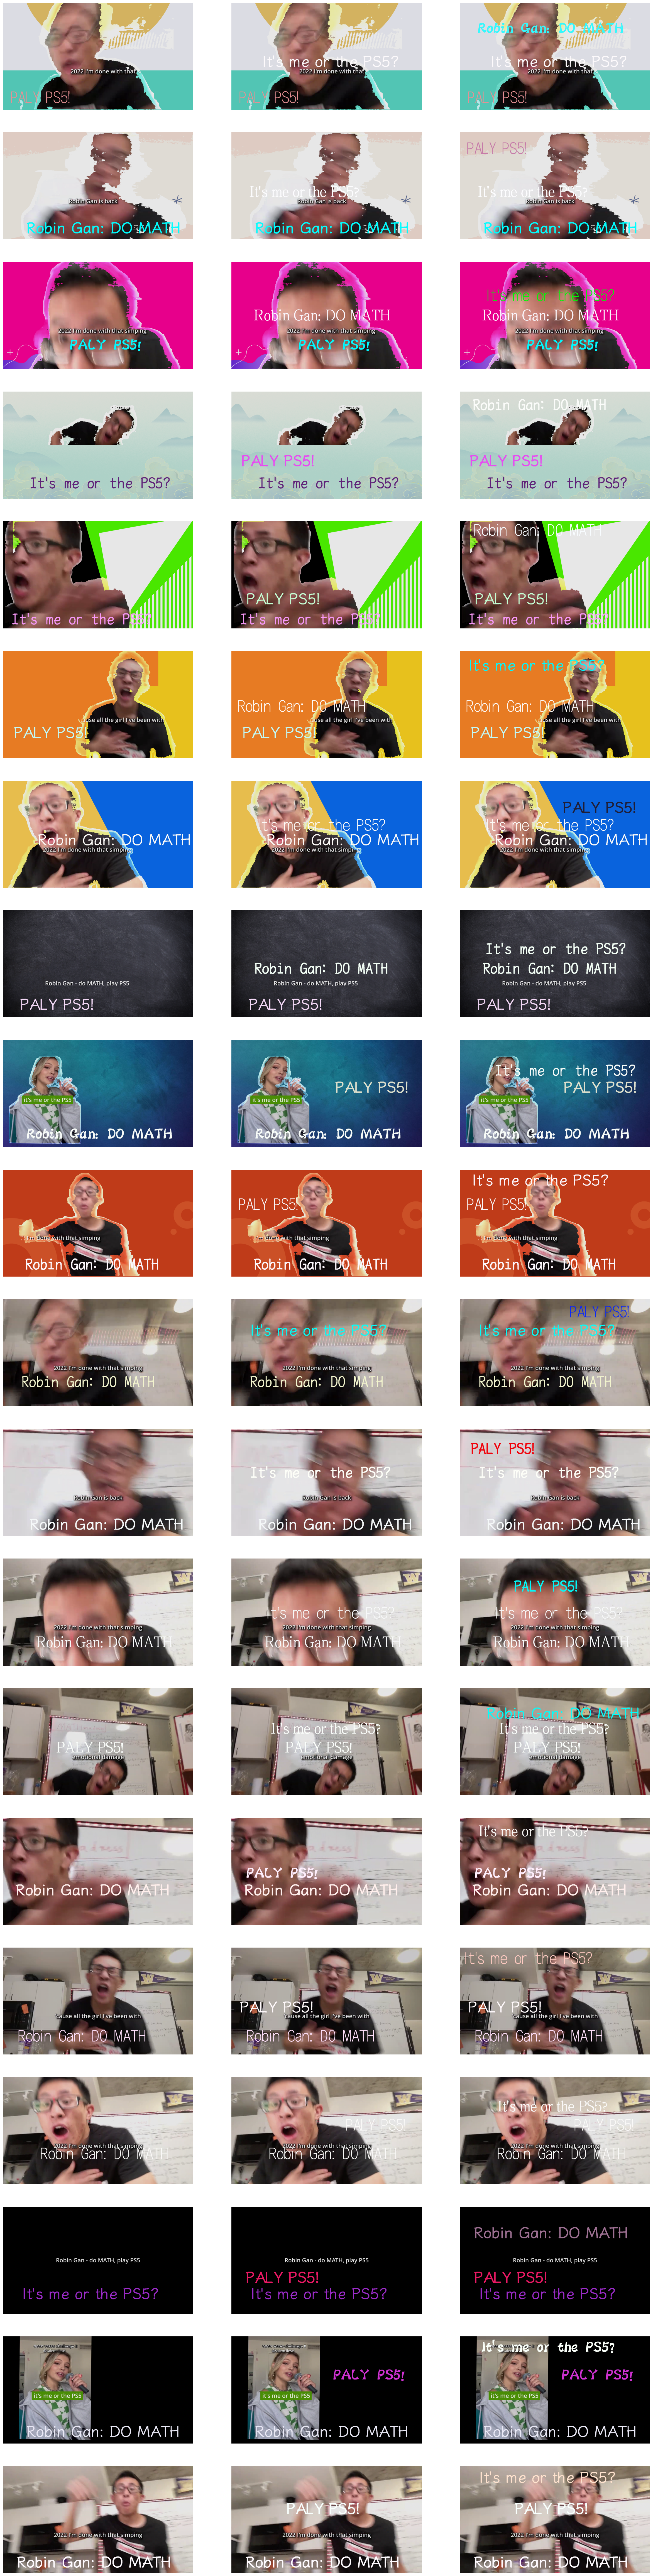

with backgrounds from base:


100%|██████████| 2/2 [00:12<00:00,  6.11s/it]


FID:  442.8426954490547

without backgrounds from base:


100%|██████████| 2/2 [00:10<00:00,  5.41s/it]


FID:  398.3988748524948


In [97]:
covers = main()